Imports

In [2]:
import numpy as np
import pandas as pd
from fredapi import Fred
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import seaborn as sns
plt.style.use('ggplot')

from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
FRED_API_KEY = "29b81578246f3b1d8661dfdb956124ba"
fred = Fred(api_key=FRED_API_KEY)

Get time series data

In [4]:
df = fred.get_series('VIXCLS')
df = pd.DataFrame(df, columns=['VIX'])
df.index = pd.to_datetime(df.index, format='%Y-%m-%D')
df.set_index
#df = df.asfreq("d")
df = df.ffill()
#df = df[df['VIX'].notna()]

df = df.iloc[-500:]

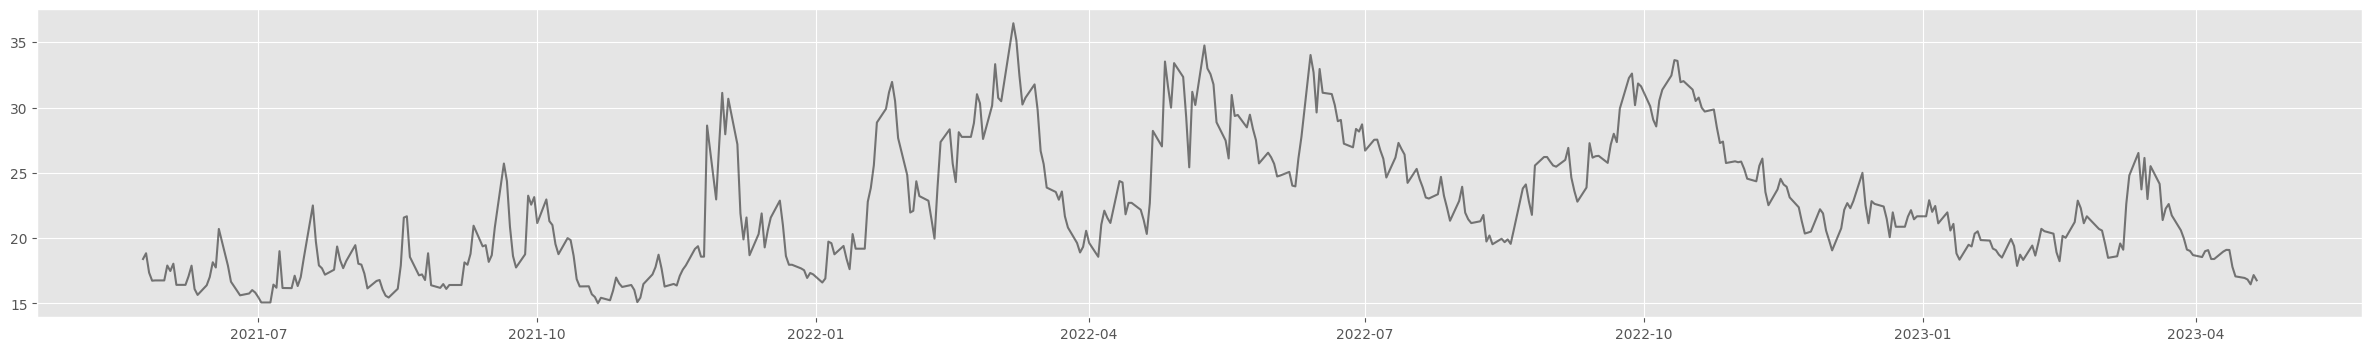

In [5]:
plt.figure(figsize=(30,4))
plt.plot(df, color='black', alpha=0.5)
plt.show()

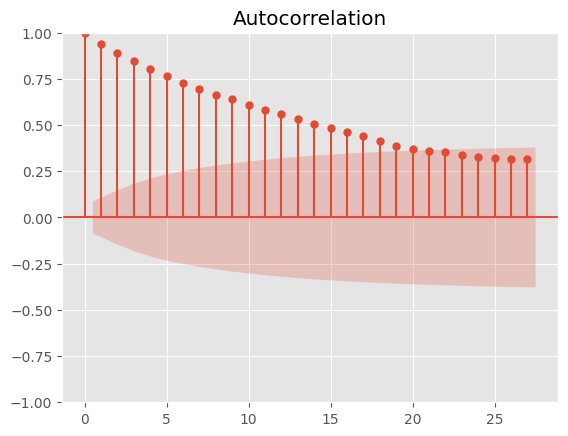

In [6]:
plot_acf(df)
plt.show()


/opt/homebrew/Caskroom/miniforge/base/envs/tensorrun/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


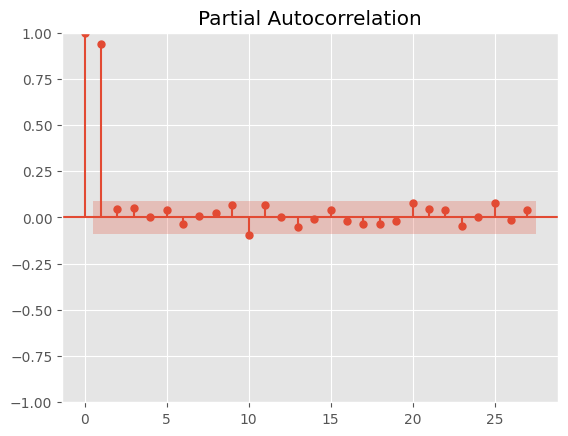

In [7]:
plot_pacf(df)
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries, mean_window = 7, var_window = 7):
    # Determing rolling statistics
    rolmean = timeseries.rolling(window = mean_window).mean()
    rolstd = timeseries.rolling(window = var_window).std()

    # Plot rolling statistics:
    plt.figure(figsize=(30,4))
    orig = plt.plot(timeseries, color='black', label='Original', alpha=0.5)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='orange', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

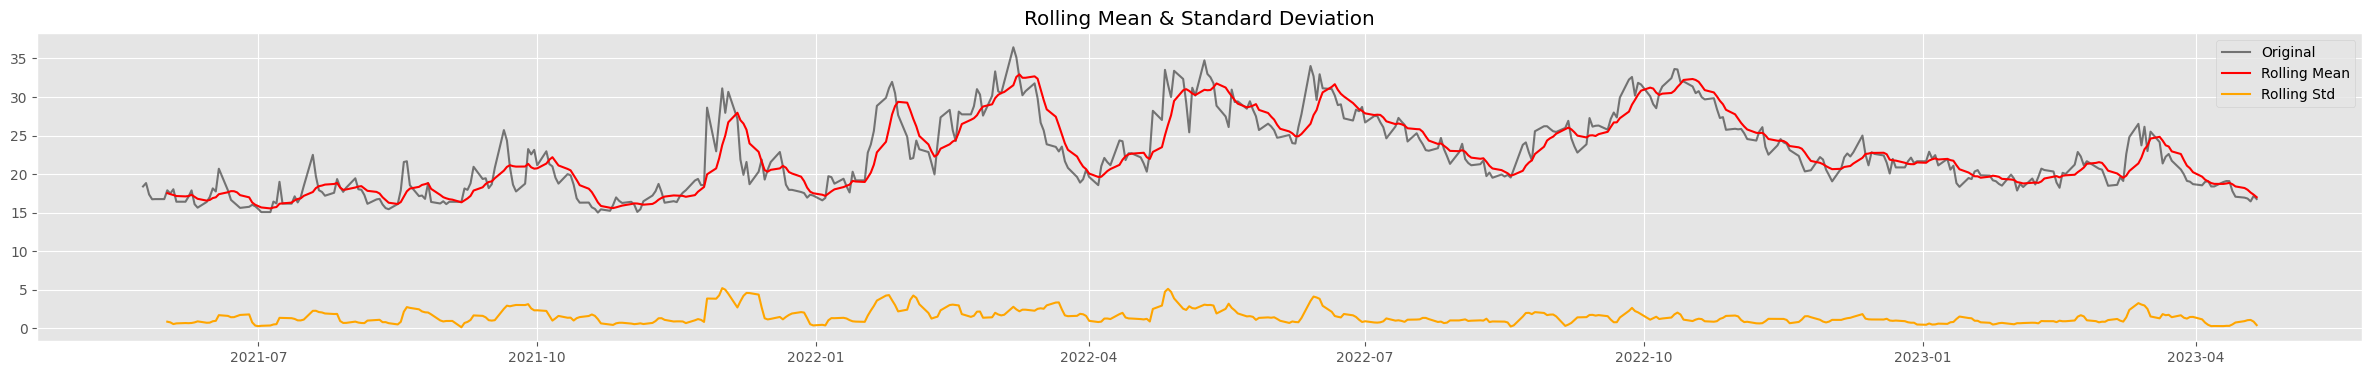

Dickey-Fuller Test:
Test Statistic                  -3.833746
p-value                          0.002580
#Lags Used                       0.000000
Number of Observations Used    499.000000
Critical Value (1%)             -3.443523
Critical Value (5%)             -2.867350
Critical Value (10%)            -2.569864
dtype: float64


In [9]:
test_stationarity(df)

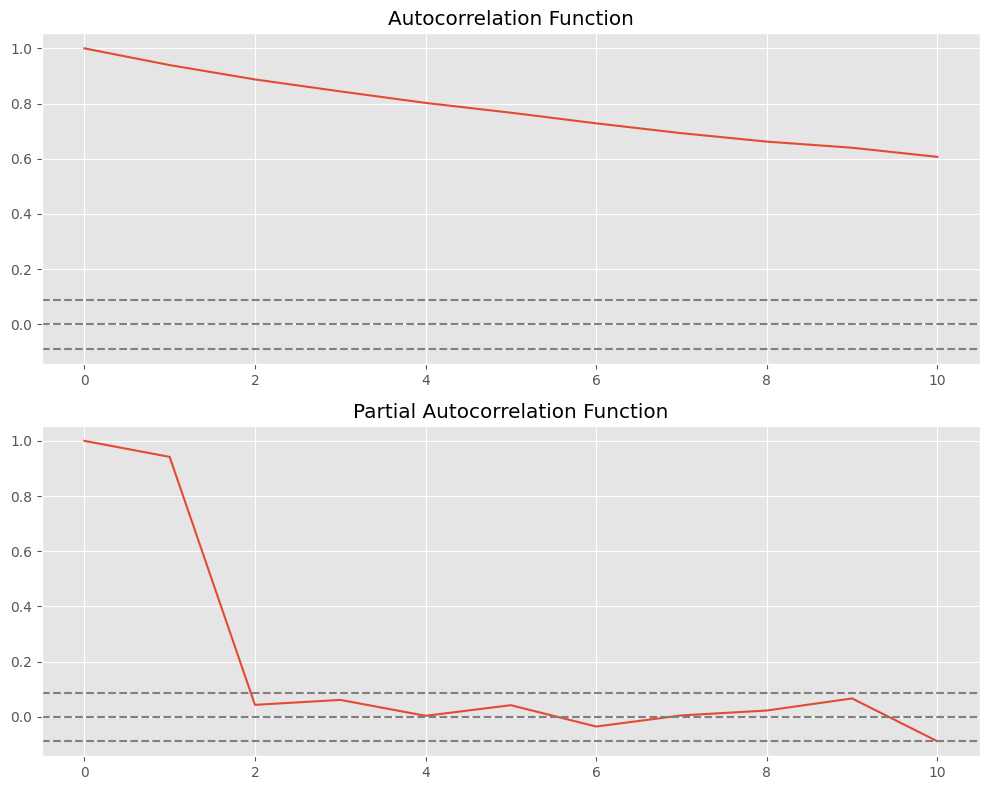

In [10]:
from statsmodels.tsa.stattools import acf, pacf

acf = acf(df, nlags=10)
pacf = pacf(df, nlags=10, method='ols')

fig, ax = plt.subplots(2, 1, sharey=True, figsize=(10, 8))

for i, (ac, ac_name) in enumerate([(acf, 'Autocorrelation Function'), (pacf, 'Partial Autocorrelation Function')]):
    ax[i].plot(ac)
    ci_boundary = 1.96/np.sqrt(len(df))
    for ci_line in [0, -ci_boundary, ci_boundary]:
        ax[i].axhline(y=ci_line, linestyle='--', color='gray')
    ax[i].title.set_text(ac_name)
    
plt.tight_layout()

In [11]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.statespace import sarimax
from sklearn.metrics import mean_squared_error

In [12]:
arima_model = AutoReg(endog=df, lags=3).fit()
fitted_values_arima = arima_model.predict()

/opt/homebrew/Caskroom/miniforge/base/envs/tensorrun/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency B will be used.
  self._init_dates(dates, freq)


Argumentere for at valgene er robust. Vise flere kombinasjoner av modeller.
Qlike.

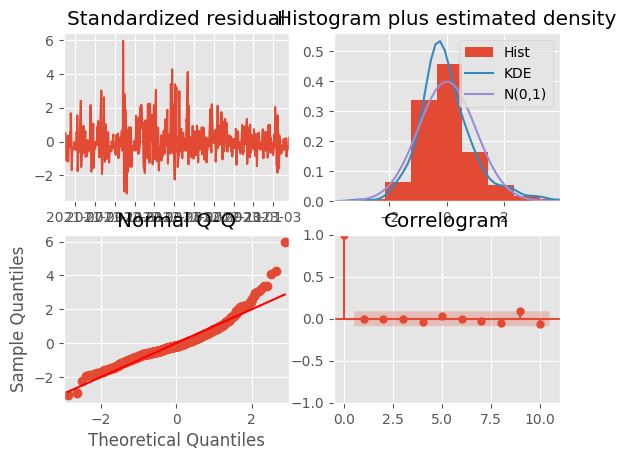

In [13]:
arima_model.plot_diagnostics()
plt.show()

Leptokurtic residuals. Higher peak and heavier tails than normal distribution. AR model is not accounting for all the information in the data. May suggest non-linear patterns or outliers in the data that the AR model is not capturing.

In [14]:
fitted_values_arima


2021-05-24          NaN
2021-05-25          NaN
2021-05-26          NaN
2021-05-27    17.671573
2021-05-28    17.159997
                ...    
2023-04-17    17.466379
2023-04-18    17.288547
2023-04-19    17.137410
2023-04-20    16.799032
2023-04-21    17.434407
Freq: B, Length: 500, dtype: float64

/var/folders/nh/rykc7t6j5rq5c3w33l4blqj00000gn/T/ipykernel_33137/3228546238.py:2: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(df['2022'], color='black', alpha=0.5)


Text(0.5, 1.0, 'MSE: 2.70')

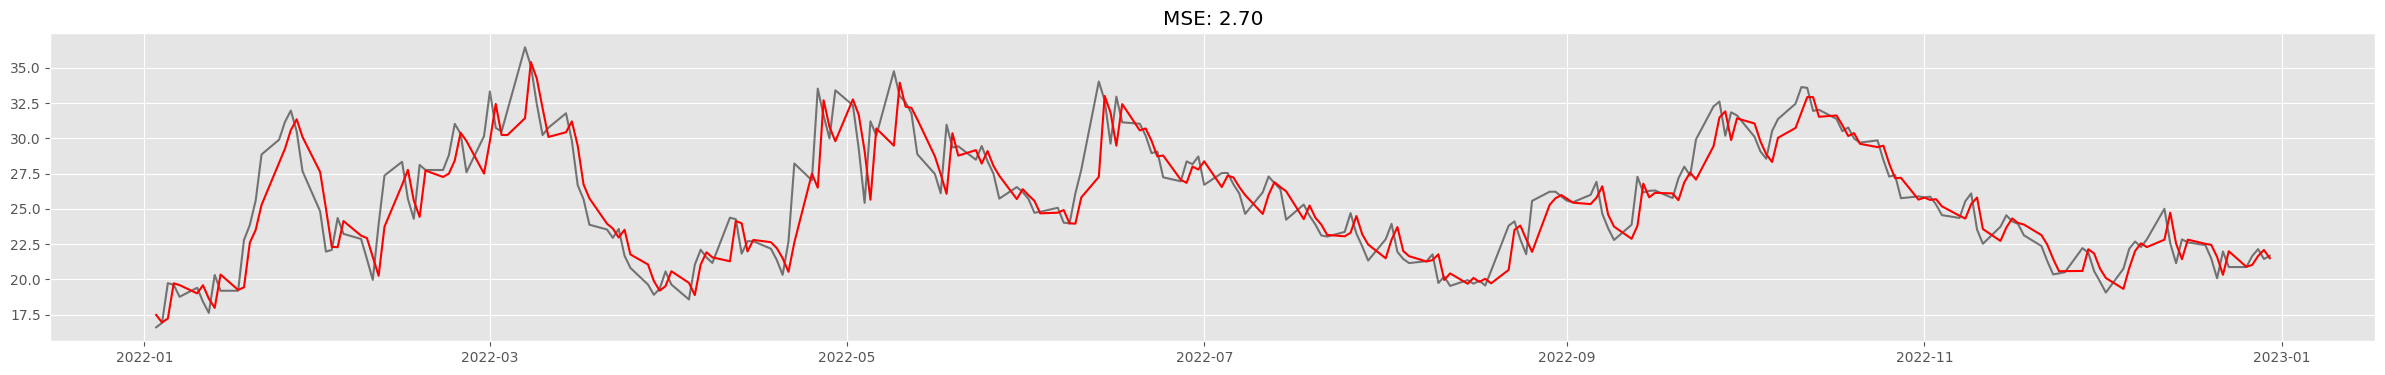

In [15]:
plt.figure(figsize=(30,4))
plt.plot(df['2022'], color='black', alpha=0.5)
plt.plot(fitted_values_arima['2022'], color='red')
mse = mean_squared_error(df[3:],fitted_values_arima[3:])
plt.title(f'MSE: {mse:.2f}')

<AxesSubplot: >

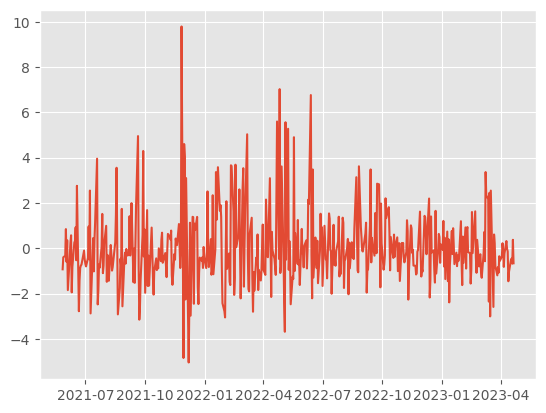

In [16]:
sns.lineplot(arima_model.resid)

NormaltestResult(statistic=137.56214682758167, pvalue=1.345114818104236e-30)


/opt/homebrew/Caskroom/miniforge/base/envs/tensorrun/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


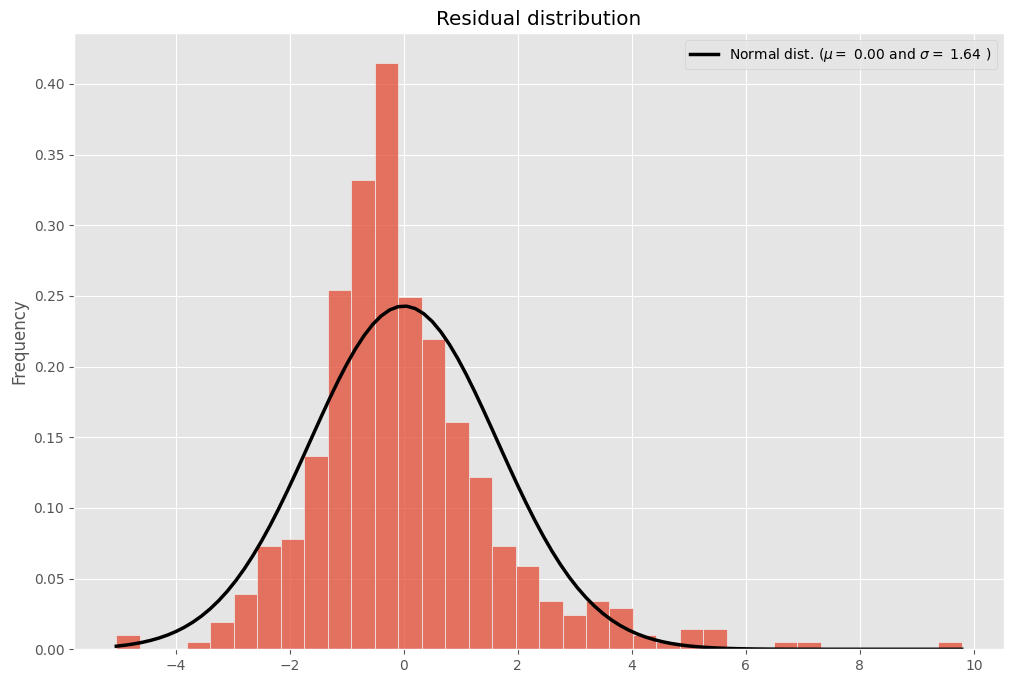

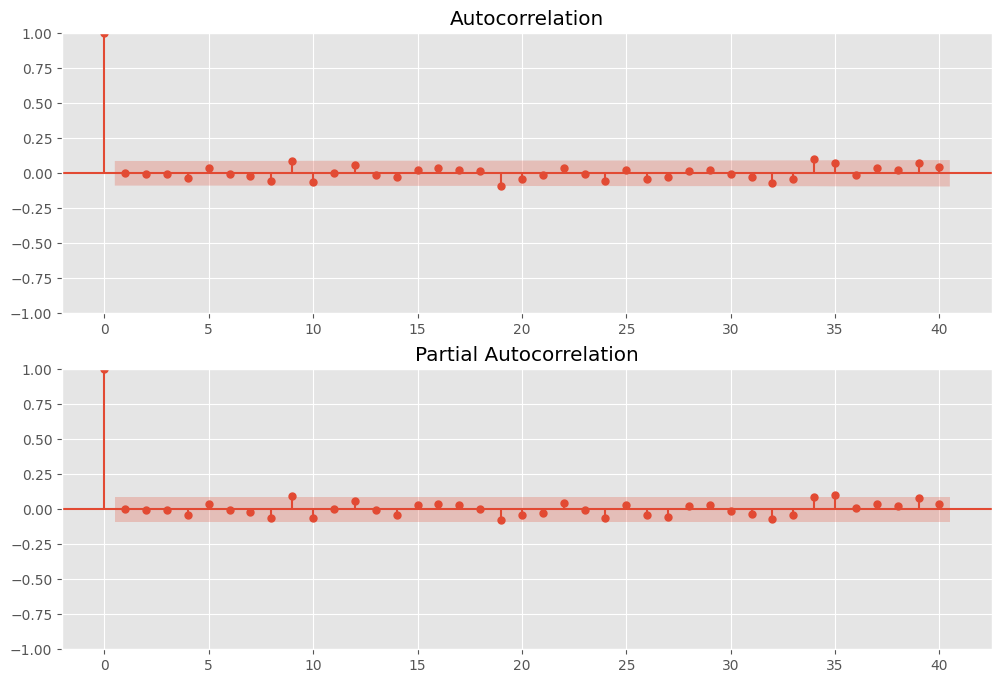

In [17]:
from scipy import stats
from scipy.stats import normaltest, norm
import seaborn as sns
import statsmodels.api as sm

def plot_residuals(residuals): 
    print(normaltest(residuals))

    fig = plt.figure(figsize=(12,8))
    ax0 = fig.add_subplot(111)

    # Plot the distribution
    xx = np.linspace(residuals.min(), residuals.max(), 100)
    sns.histplot(residuals, ax = ax0, stat='density')
    (mu, sigma) = stats.norm.fit(residuals)  
    ax0.plot(xx, norm.pdf(xx, loc=mu, scale=sigma), color="black", lw=2.5)
    plt.legend([f'Normal dist. ($\mu=$ {mu:.2f} and $\sigma=$ {sigma:.2f} )'], loc='best')
    plt.ylabel('Frequency')
    plt.title('Residual distribution')

    # ACF and PACF
    fig = plt.figure(figsize=(12,8))
    ax1 = fig.add_subplot(211)
    fig = sm.graphics.tsa.plot_acf(residuals, lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = sm.graphics.tsa.plot_pacf(residuals, lags=40, ax=ax2)
    
plot_residuals(arima_model.resid)

/var/folders/nh/rykc7t6j5rq5c3w33l4blqj00000gn/T/ipykernel_33137/3303089053.py:7: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(df['2023'], color='black', alpha=0.5)


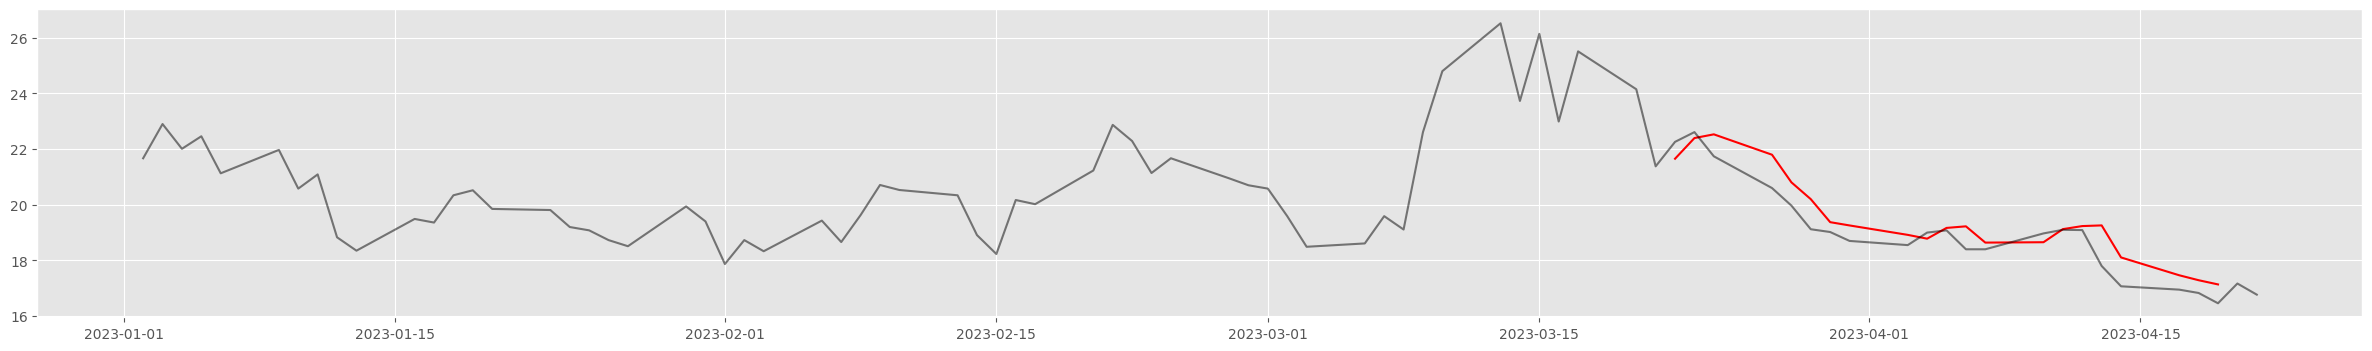

In [18]:
# In sample forecasting
n = len(arima_model.fittedvalues) 
predicted = arima_model.predict(n - 20, n)

plt.figure(figsize=(30, 4))
plt.plot(predicted, color='red')
plt.plot(df['2023'], color='black', alpha=0.5)

/opt/homebrew/Caskroom/miniforge/base/envs/tensorrun/lib/python3.8/site-packages/statsmodels/tsa/deterministic.py:302: UserWarning: Only PeriodIndexes, DatetimeIndexes with a frequency set, RangesIndexes, and Index with a unit increment support extending. The index is set will contain the position relative to the data length.
  fcast_index = self._extend_index(index, steps, forecast_index)


<AxesSubplot: >

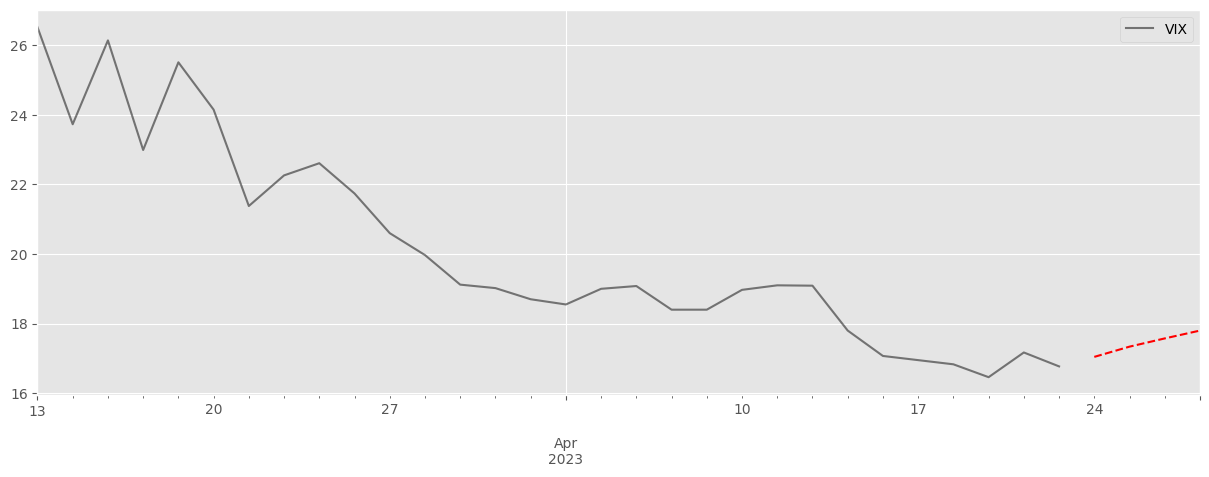

In [19]:
# Out of sample forecasting
n = len(df)
fcast = arima_model.predict(n, n+3, dynamic=True)
fig, ax = plt.subplots(figsize=(15, 5))
df[-30:].plot(ax = ax, color='black', alpha=0.5)
fcast.plot(ax = ax, style='r--')

Sliding window approach

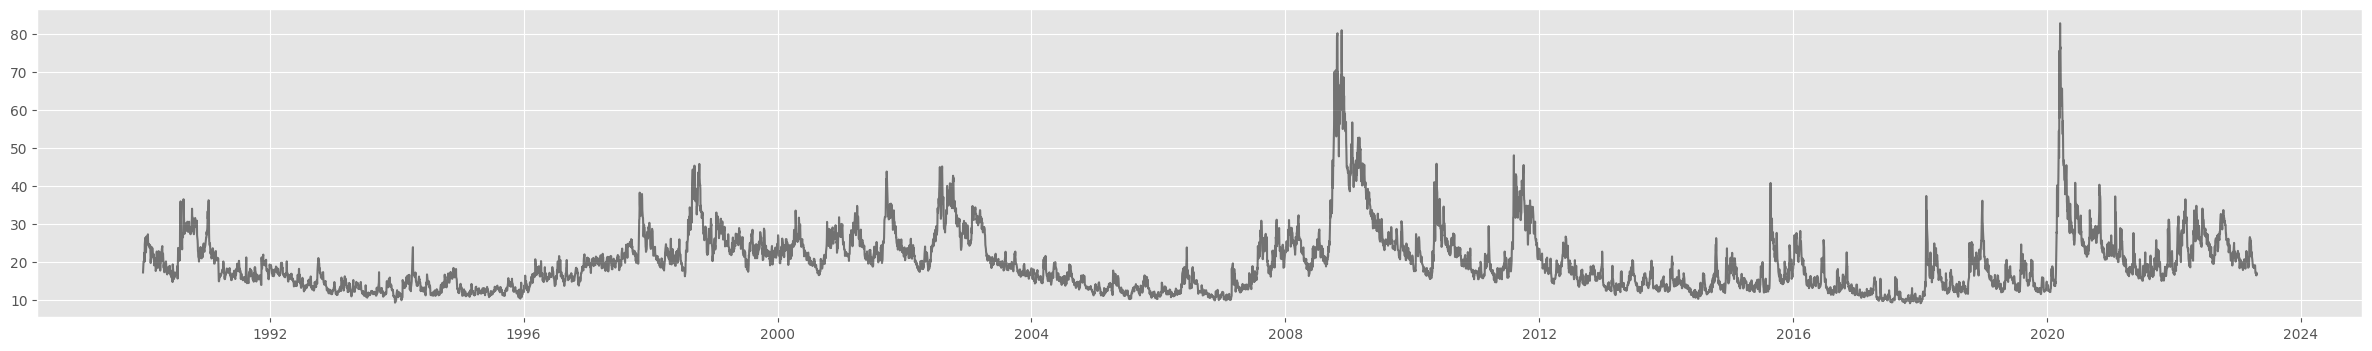

In [20]:
FRED_API_KEY = "29b81578246f3b1d8661dfdb956124ba"
fred = Fred(api_key=FRED_API_KEY)
VIX = fred.get_series('VIXCLS')
VIX = pd.DataFrame(VIX, columns=['VIX'])
VIX.index = pd.to_datetime(VIX.index, format='%Y-%m-%D')
df = VIX.ffill()
plt.figure(figsize=(30,4))
plt.plot(df, color='black', alpha=0.5)
plt.show()

In [21]:
column_indices = {name: i for i, name in enumerate(df.columns)}
n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]
num_features = df.shape[1]

In [23]:
from window_generator import WindowGenerator

w = WindowGenerator(input_width=100, 
                    label_width=1,
                    shift=1,
                    train_df=train_df,
                    val_df=val_df,
                    test_df=test_df,
                    n_splits=3,
                    train_splits=3,
                    test_splits=1,
                    scale=False)

In [94]:
y_train = np.concatenate([y for x, y in w.train], axis=0)
x_train = np.concatenate([x for x, y in w.train], axis=0)

y_val = np.concatenate([y for x, y in w.val], axis=0)
x_val = np.concatenate([x for x, y in w.val], axis=0)

y_val.shape

(1638, 1, 1)

In [134]:
predictions = []
resid = []

for x, y in zip(x_val, y_val):
    arima_model = AutoReg(endog=x, lags=3).fit()
    predictions.append(arima_model.predict(101, 101))
    resid.append(y[0] - arima_model.predict(101, 101))
    

In [135]:
resid = np.array(resid)

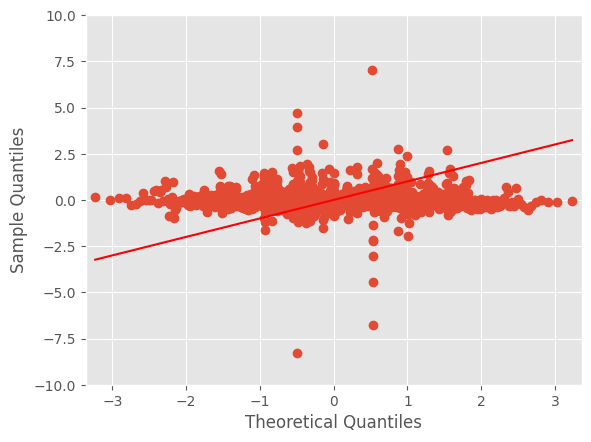

In [136]:
from statsmodels.api import qqplot

#sns.histplot(resid)
#plt.xlim(-5, 5)

qqplot(resid, line='s', fit=True)
plt.ylim(-10, 10)
plt.show()

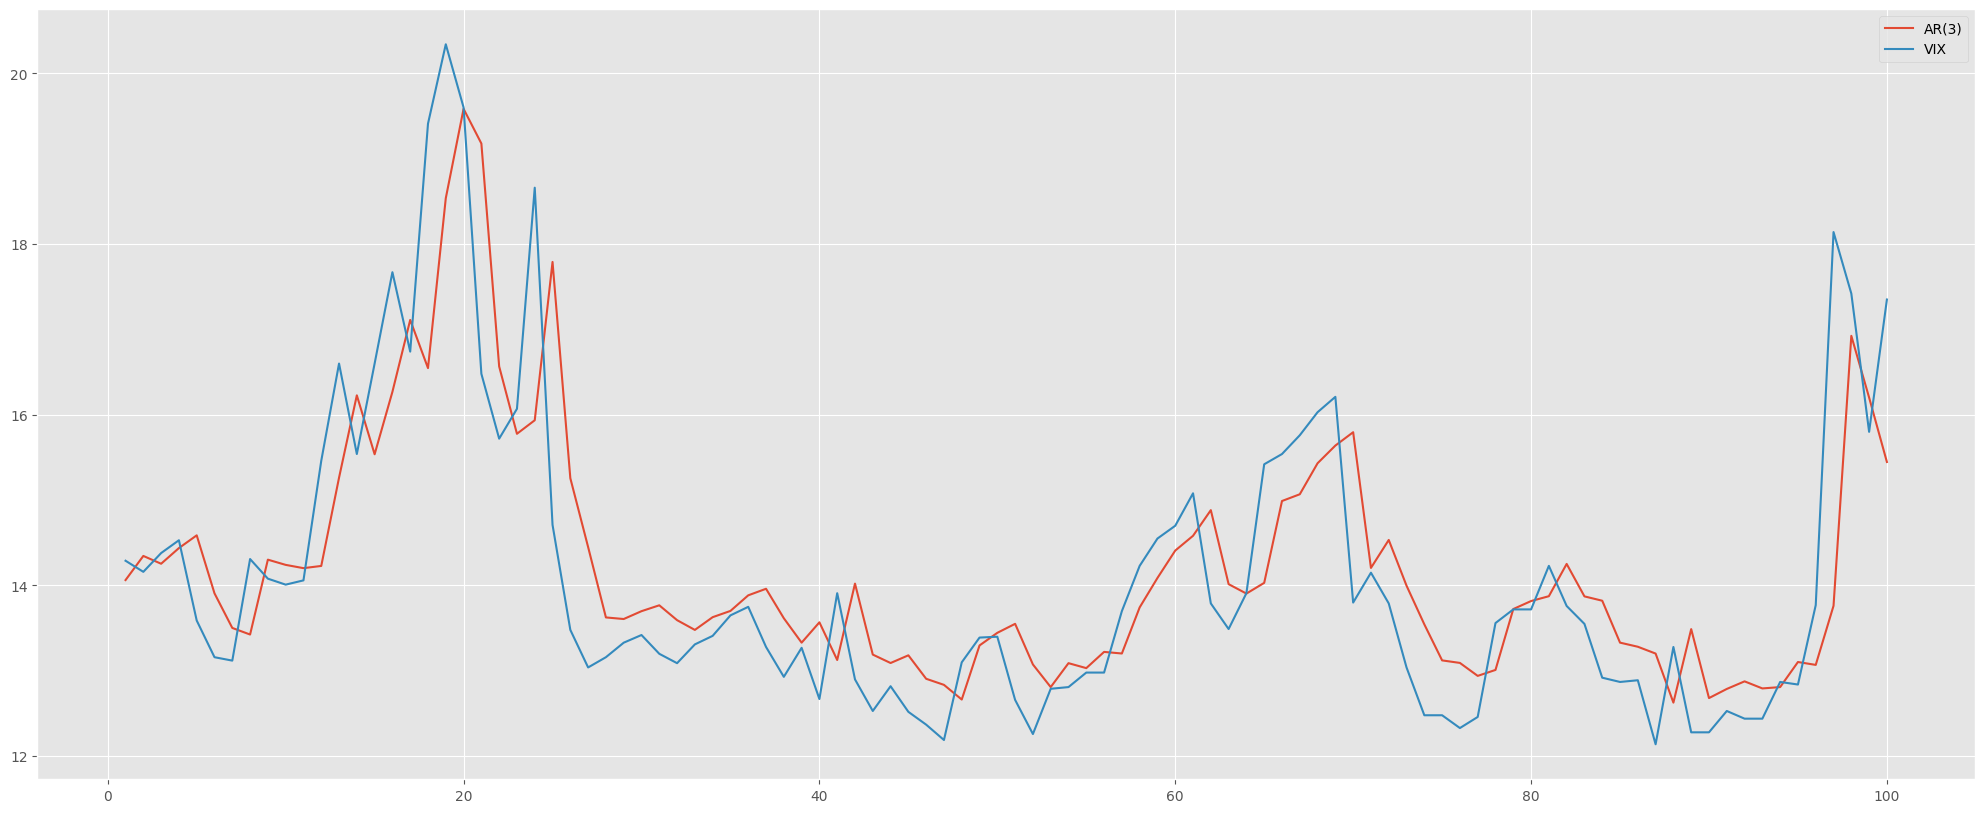

In [137]:
dates = np.arange(1, len(predictions) + 1)

fig, ax = plt.subplots(figsize = (25,10))

plt.plot(dates[:100], predictions[:100], label = "AR(3)")
plt.plot(dates[:100], y_val.reshape((len(predictions), -1))[:100], label = "VIX")
plt.legend()
